In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def load_data(
    filename,
    value,
    columns=[
        "TERYT",
        "nazwa",
        "2002",
        "2003",
        "2004",
        "2005",
        "2006",
        "2007",
        "2008",
        "2009",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
        "2020",
        "2021",
        "2022",
        "drop",
    ],
):
    df = pd.read_csv(filename, sep=";")
    df.columns = columns

    df = df.drop(columns=["drop"])
    df = df.melt(id_vars=["TERYT", "nazwa"])

    df.columns = ["TERYT", "wojewodztwo", "rok", value]

    df[value] = df[value].apply(lambda s: float(s.replace(",", ".")))
    df["rok"] = df["rok"].apply(lambda s: int(s))

    df = df.sort_values(["TERYT", "wojewodztwo", "rok"])
    df[f"{value}_change"] = df.groupby(["TERYT", "wojewodztwo"])[
        value].pct_change()
    df[f"{value}_change"] = 100 * df[f"{value}_change"]

    return df


In [3]:
bezrobocie = load_data(
    "data/stopa_bezrobocia.csv",
    "bezrobocie",
    [
        "TERYT",
        "nazwa",
        "2004",
        "2005",
        "2006",
        "2007",
        "2008",
        "2009",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
        "2020",
        "2021",
        "2022",
        "drop",
    ],
)

wynagrodzenie = load_data(
    "data/przecietne_wynagrodzenie_miesieczne.csv", "wynagrodzenie"
)
emerytura = load_data("data/przecietna_emerytura.csv", "emerytura")

In [4]:
gus_data = pd.merge(
    pd.merge(
        bezrobocie,
        wynagrodzenie,
        how="inner",
        left_on=("TERYT", "wojewodztwo", "rok"),
        right_on=("TERYT", "wojewodztwo", "rok"),
    ),
    emerytura,
    how="inner",
    left_on=("TERYT", "wojewodztwo", "rok"),
    right_on=("TERYT", "wojewodztwo", "rok"),
)

gus_data = gus_data.melt(id_vars=("TERYT", "wojewodztwo", "rok"))

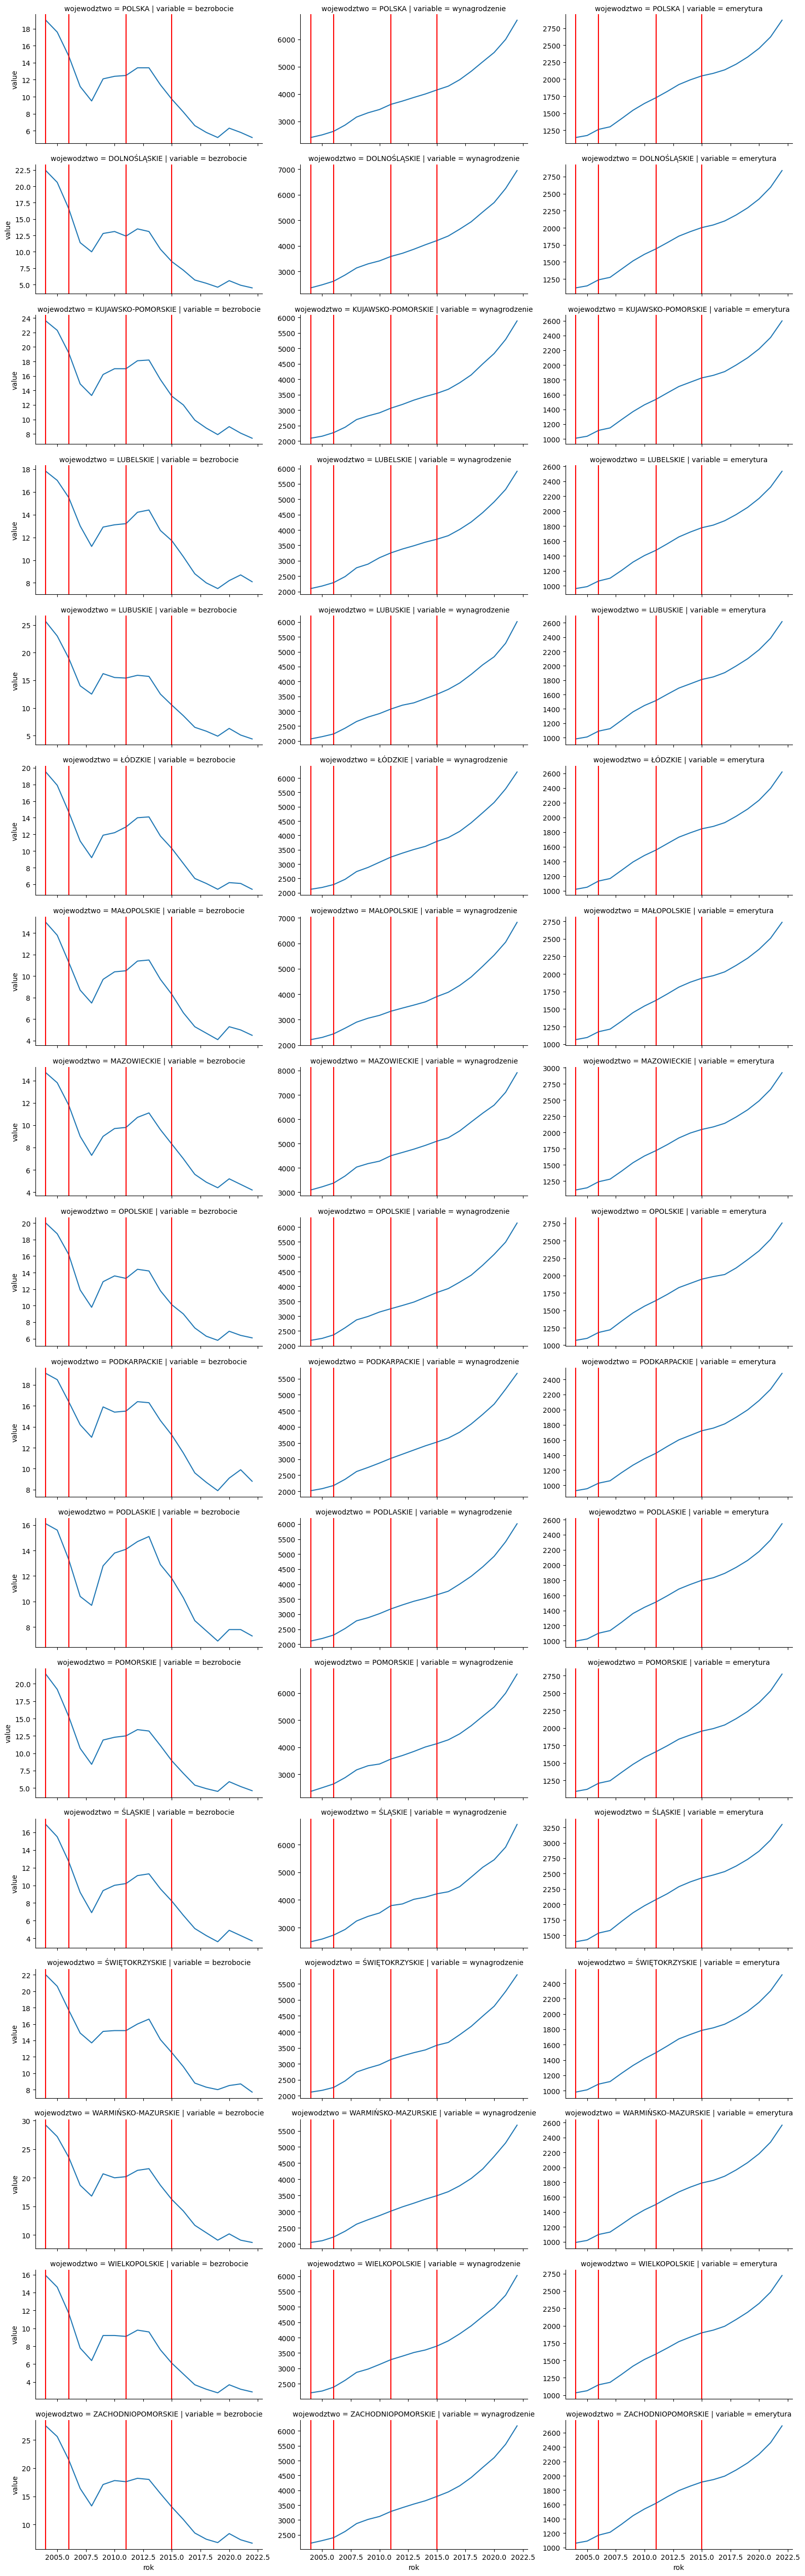

In [5]:
g = sns.FacetGrid(
    gus_data[~gus_data["variable"].str.endswith("_change")].dropna(),
    col="variable",
    row="wojewodztwo",
    sharex=True,
    sharey=False,
    aspect=16 / 9,
)
g.map(sns.lineplot, "rok", "value")
g.map(plt.axvline, x=2004, color="red")  # początek rządów SLD
g.map(plt.axvline, x=2006, color="red")  # początek rządów PiS+Samoobrona+LPR
g.map(plt.axvline, x=2011, color="red")  # początek rządów PO+PLS
g.map(plt.axvline, x=2015, color="red")  # początek rządów PiS

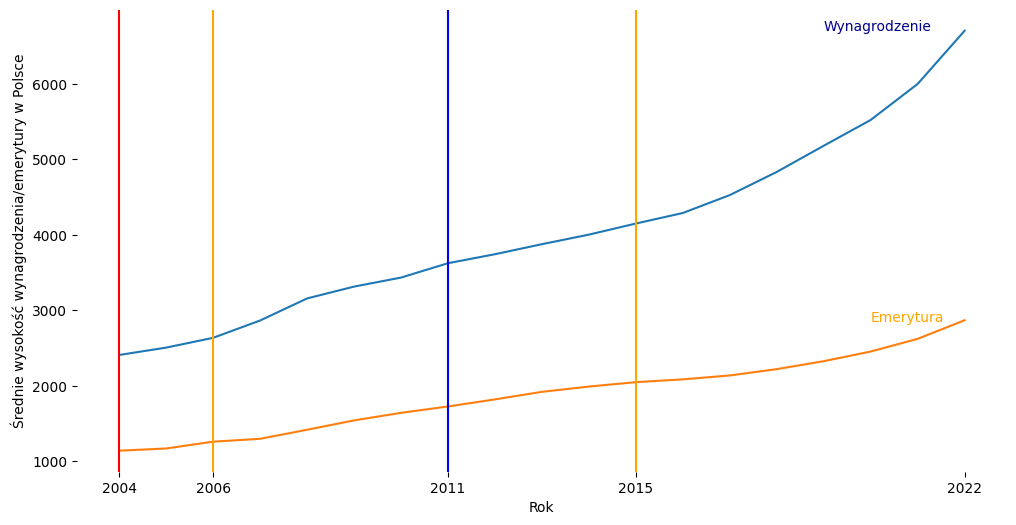

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=gus_data[
        (~gus_data["variable"].str.endswith("_change"))
        & (gus_data["wojewodztwo"] == "POLSKA")
        & (gus_data["variable"].isin(["wynagrodzenie", "emerytura"]))
    ].dropna(),
    x="rok",
    y="value",
    hue="variable",
)

plt.annotate("Wynagrodzenie", xy=(2019, 6700), color="darkblue")
plt.annotate("Emerytura", xy=(2020, 2850), color="orange")

plt.axvline(x=2004, color="red")  # początek rządów SLD
plt.axvline(x=2006, color="orange")  # początek rządów PiS+Samoobrona+LPR
plt.axvline(x=2011, color="blue")  # początek rządów PO+PLS
plt.axvline(x=2015, color="orange")  # początek rządów PiS

plt.xticks([2004, 2006, 2011, 2015, 2022])
plt.xlabel("Rok")
plt.ylabel("Średnie wysokość wynagrodzenia/emerytury w Polsce")

ax.legend().remove()

for b in ["bottom", "top", "right", "left"]:
    ax.spines[b].set_color(None)

plt.show()